<h1 align="center">Simple Tutorial for Allen Brain Observatory Visual Coding Dataset</h1> 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Brain Observatory Setup

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = r'/Users/saskiad/Code/brain_observatory/manifest_v1point3.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

`manifest_file` is a path to the manifest file.  This needs to reflect where you are storing and accessing the data. When you first run this, leave it out so that a manifest file will be created in your working directory, and data will be downloaded to this location. Once you have created a manifest file , point the Cache to this code in future work to avoid re-downloading data.

<b>get_ophys_experiment_data</b> returns the data object giving us access to everything in the NWB file for a single imaging session

In [8]:
session_id = 501559087
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

2021-06-15 14:46:03,204 allensdk.api.api.retrieve_file_over_http INFO     Downloading URL: http://api.brain-map.org/api/v2/well_known_file_download/514429113


Here we will use DF/F traces that are available in the NWB file for the data_set. Extracted events are also available for analysis.
Get the DF/F traces, running speed, and stimulus epoch table to plot the entire session in one figure

static_gratings blue
natural_scenes orange
spontaneous green
natural_movie_one red


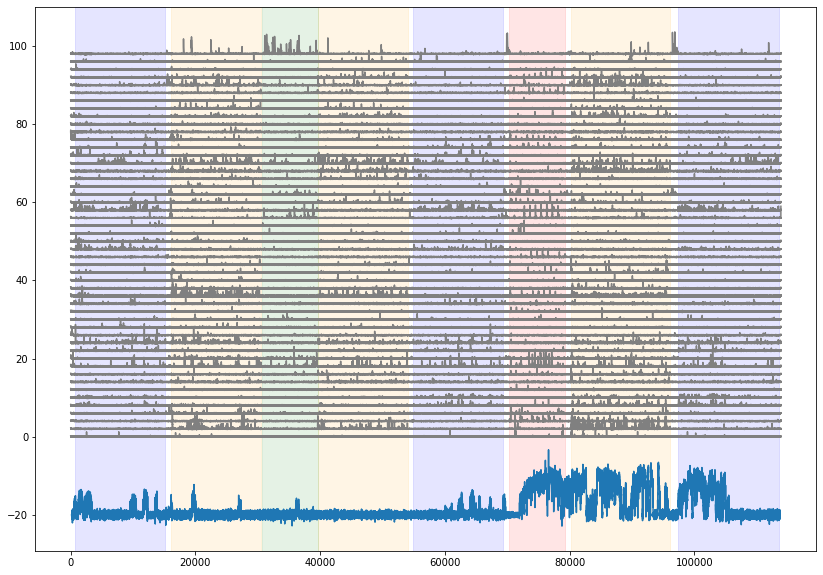

In [74]:
#get data
ts, dff = data_set.get_dff_traces()   # gets dff traces for all neurons
dxcm, tsd = data_set.get_running_speed()     #gets running speed of mouse in cm/s
stim_epoch = data_set.get_stimulus_epoch_table()    #gets dataframe of stimulus epochs

#create simple plot of the first 50 cells
fig = plt.figure(figsize=(14,10))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')

#add the running speed
plt.plot((0.2*dxcm)-20)

#shade each stimulus epoch
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    print(stim_name, colors[c])
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

Each stimulus has its own stimulus table, a dataframe of the start and end times of each trial as well as the stimulus condition for that trial. Here we'll look at the Natural Scene stimulus table to find when different images were presented during this session

In [13]:
natural_scene_table = data_set.get_stimulus_table('natural_scenes')
natural_scene_table.head()

,frame,start,end
0,81,16100,16107
1,33,16108,16115
2,76,16115,16122
3,13,16123,16130
4,56,16130,16137


For cell index <b>1</b>, plot the responses to each presentation of image <b>101</b>, color the trials based on whether the mouse was running or not.

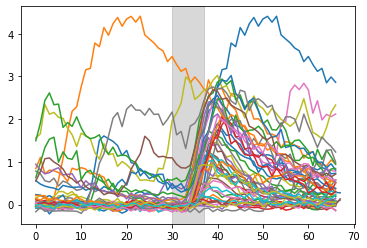

In [81]:
scene_number = 101
stim_subset = natural_scene_table[natural_scene_table.frame==scene_number]

cell_index = 1
for i in range(len(stim_subset)):
    plt.plot(dff[cell_index,stim_subset.start.iloc[i]-30:stim_subset.end.iloc[i]+30])

plt.axvspan(30,37, color='gray',alpha=0.3)

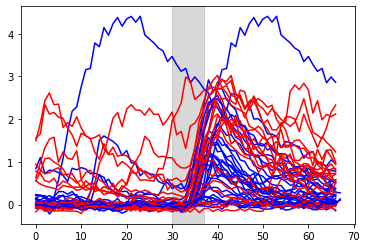

In [82]:
for i in range(len(stim_subset)):    
    if dxcm[stim_subset.start.iloc[i]:stim_subset.end.iloc[i]].mean()>1:
        plot_color = 'red'    #red = running
    else:
        plot_color = 'blue'    #blue = stationary
    plt.plot(dff[cell_index,stim_subset.start.iloc[i]-30:stim_subset.end.iloc[i]+30], color=plot_color)
plt.axvspan(30,37, color='gray',alpha=0.3)

### Stimulus Template

The images and movies presented during the session area also included in the NWB file as the <b>stimulus template</b>. Stimuli that are generated programmatically (eg. drifting and static gratings) do not have a stimulus template. There are tools in the SDK to recreate these stimuli.

Get and plot the image that corresponds to the response plotted above:

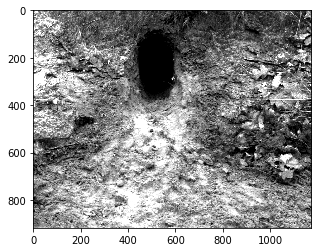

In [69]:
natural_scene_template = data_set.get_stimulus_template('natural_scenes')

plt.imshow(natural_scene_template[scene_number,:,:], cmap='gray')

### Metadata
Each experiment contains metadata about the mouse and the experiment. This will tell you the sex, age, genotype of the mouse, the imaging area and depth, what machine the data was collected on, which stimulus session was presented, among other things.

In [70]:
data_set.get_metadata()

{'sex': 'male',
 'targeted_structure': 'VISp',
 'ophys_experiment_id': 501559087,
 'experiment_container_id': 511510736,
 'excitation_lambda': '910 nanometers',
 'indicator': 'GCaMP6f',
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Cux2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/Ai93(TITL-GCaMP6f)',
 'session_start_time': datetime.datetime(2016, 2, 4, 10, 25, 24),
 'session_type': 'three_session_B',
 'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
 'cre_line': 'Cux2-CreERT2/wt',
 'imaging_depth_um': 175,
 'age_days': 104,
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.2',
 'pipeline_version': '3.0'}

### Finding data
The Allen Brain Observatory contains over 1300 2-photon calcium imaging sessions that are available for you to download and analyze. They sample 6 different <b>cortical areas</b>, 14 transgenic <b>Cre lines</b>, and 4 <b>cortical layers</b> or imaging depths. For each set of cells, we collected three separate imaging <b>sessions</b> to sample several different <b>stimulus types</b>, creating a complete <b>experiment container</b>.

!['Diagram of containers'](http://alleninstitute.github.io/AllenSDK/_static/container_session_layout.png)

The brain observatory cache of the AllenSDK allows you to use the targeted area, Cre line, imaging depth, or stimulus type to identify specific sessions that you are interested in analyzing. The <b>Visual Coding Cheat Sheet</b> as well as many tutorials are available to help you navigate the AllenSDK to find data based on these criteria.